# ET-287 - Processamento de sinais usando redes neurais

_Aluno: Denys Derlian Carvalho Brito_

---

## Projeto Exame - Classificação de Desempenho em Criptografia Quântica com Redes Neurais Profundas

**Objetivo:** Desenvolver um classificador baseado em redes neurais profundas capaz de prever, a partir de variáveis heterogêneas de um ambiente de criptografia quântica, a classe de desempenho (“Ótimo” vs. “Subótimo”) com alta acurácia e boa capacidade de generalização.


No contexto da computação quântica, a criptografia quântica oferece novos paradigmas de segurança baseados em princípios de mecânica quântica. Sob essa perspectiva, a aplicação de técnicas de aprendizado de máquina tem sido explorada para otimizar e aprimorar o desempenho dos sistemas de criptografia quântica. Todavia, a complexidade inerente a esses sistemas, aliada à heterogeneidade dos dados gerados, impõe desafios significativos para a construção de modelos preditivos eficazes. Nesse cenário, propõe uma abordagem que foca na classificação da **performance da rede** de forma integrada, considerando não apenas os parâmetros quânticos e de segurança, mas também métricas de performance de rede, características de _big data_ e utilização de recursos computacionais, que em conjunto determinam a viabilidade prática dos sistema em cenários operacionais reais.

---

## 3. Criar um modelo MLP paralelo, que trata variáveis numéricas e categóricas separadamente

_Também adicionado o tratamento do desbalanceamento de dados com um `binary_focal_loss` customizado._

### Características da Arquitetura Paralela:

**Ramo Numérico:**
- Processa features numéricas através de camadas MLP customizáveis
- Normalização com BatchNormalization
- Dropout para regularização

**Ramo Categórico:**
- Embeddings individuais para cada variável categórica
- Dimensão dos embeddings calculada automaticamente: `min(50, max(2, int(card^0.25) + 1))`
- Concatenação dos embeddings seguida por camadas MLP customizáveis

**Fusão e Camadas Finais:**
- Concatenação dos outputs dos dois ramos
- Camadas MLP adicionais customizáveis para aprendizado conjunto
- Output com ativação sigmoid para classificação binária

**Parâmetros Configuráveis:**
- `numeric_layers`: lista com número de neurônios para cada camada do ramo numérico
- `categorical_layers`: lista com número de neurônios para cada camada do ramo categórico
- `merged_layers`: lista com número de neurônios para camadas após fusão
- `activation`: função de ativação (relu, elu, selu, etc.)
- `focal_gamma` e `focal_alpha`: parâmetros da Focal Loss para lidar com desbalanceamento

In [1]:
# Importart bibliotecas a partir do módulo config
from modules.config import *

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-18 22:05:25.185619: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-18 22:05:25.228728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-18 22:05:26.995483: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see sl

Num GPUs Available:  1


In [2]:
# Carregar os dados pre-processados
df_preprocessed = pd.read_csv("./data/preprocessed/df_preprocessed.csv")
X_numerical_df = pd.read_csv("./data/preprocessed/X_numerical_preprocessed.csv")
X_categorical_df = pd.read_csv("./data/preprocessed/X_categorical_preprocessed.csv")
y = pd.read_csv("./data/preprocessed/y_preprocessed.csv")


TARGET_VARIABLE = 'Performance_Target'
CATEGORICAL_COLUMNS = df_preprocessed.select_dtypes(include=['object', 'category']).columns.tolist()
NUMERICAL_COLUMNS = df_preprocessed.select_dtypes(include=['number']).columns.difference([TARGET_VARIABLE]).tolist()

In [3]:
# Definir Focal Loss (binary) com alpha balanceado
def binary_focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss para classificação binária.
    
    Args:
        gamma: foco em exemplos difíceis (quanto maior, mais foco)
        alpha: peso para classe 1 (positiva)
    """
    def loss_fn(y_true, y_pred):
        # Converter para float32 para garantir compatibilidade
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Converter gamma e alpha para float32
        gamma_t = tf.constant(gamma, dtype=tf.float32)
        alpha_t_val = tf.constant(alpha, dtype=tf.float32)
        
        # clip y_pred para estabilidade numérica
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        
        # Calcular pt (probabilidade da classe verdadeira)
        pt = tf.where(tf.equal(y_true, 1.0), y_pred, 1.0 - y_pred)
        
        # Calcular alpha_t (peso balanceado)
        alpha_t = tf.where(tf.equal(y_true, 1.0), alpha_t_val, 1.0 - alpha_t_val)
        
        # Calcular focal loss
        loss = -alpha_t * tf.pow(1.0 - pt, gamma_t) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    
    return loss_fn

In [4]:
# Calcular alpha balanceado para a Focal Loss
class_counts = y.value_counts().sort_index()
n_samples = len(y)
n_classes = len(class_counts)
alpha_balanced = class_counts[0] / n_samples  # alpha para classe positiva (1)

print(f"Distribuição das classes:")
print(class_counts)
print(f"\nAlpha balanceado para Focal Loss: {alpha_balanced:.4f}")

# Calcular cardinalidades das variáveis categóricas
categorical_cardinalities = {}
for col in X_categorical_df.columns:
    categorical_cardinalities[col] = X_categorical_df[col].nunique() + 1  # +1 para possível valor desconhecido

print(f"\nCardinalidades das variáveis categóricas:")
for col, card in categorical_cardinalities.items():
    print(f"  {col}: {card}")

Distribuição das classes:
Performance_Target
0                     918
1                      82
Name: count, dtype: int64

Alpha balanceado para Focal Loss: 0.9180

Cardinalidades das variáveis categóricas:
  Quantum_Key_Size_bits: 5
  Quantum_Protocol_Type: 5
  Key_Distribution_Method: 4
  Encryption_Strength: 4
  Attack_Type: 5
  Vulnerability_Level: 5
  Data_Variety: 5
  Data_Complexity: 4
  Real_Time_Processing: 3
  Optimization_Level: 5


In [5]:
def build_parallel_mlp(
    n_numeric, 
    categorical_cardinalities, 
    numeric_layers=[128, 64], 
    categorical_layers=[64, 32],
    merged_layers=[128],
    activation='relu',
    lr=1e-3, 
    l2_reg=1e-5, 
    dropout_rate=0.3,
    focal_gamma=2.0,
    focal_alpha=0.25
):
    """
    Uma arquitetura de rede neural robusta e competitiva para dados tabulares.
    Combina um ramo numérico e um ramo categórico com embeddings.
    
    Args:
        n_numeric: número de features numéricas
        categorical_cardinalities: dict com cardinalidade de cada variável categórica
        numeric_layers: lista com número de neurônios para cada camada do ramo numérico
        categorical_layers: lista com número de neurônios para cada camada do ramo categórico (após embeddings)
        merged_layers: lista com número de neurônios para camadas após fusão dos ramos
        activation: função de ativação a usar em todas as camadas
        lr: learning rate
        l2_reg: regularização L2
        dropout_rate: taxa de dropout
        focal_gamma: parâmetro gamma da focal loss
        focal_alpha: parâmetro alpha da focal loss
    """
    inputs = []
    
    # --- Ramo Numérico ---
    numeric_input = layers.Input(shape=(n_numeric,), name='numeric_input')
    x = layers.BatchNormalization()(numeric_input)
    
    for i, units in enumerate(numeric_layers):
        x = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), name=f'numeric_dense_{i}')(x)
        x = layers.Activation(activation)(x)
        if i < len(numeric_layers) - 1:  # Não aplicar dropout na última camada do ramo
            x = layers.Dropout(dropout_rate)(x)
    
    numeric_branch = x
    inputs.append(numeric_input)
    
    # --- Ramo Categórico com Embeddings ---
    embedding_outputs = []
    for col_name, card in categorical_cardinalities.items():
        cat_input = layers.Input(shape=(1,), dtype='int32', name=f'cat_in_{col_name}')
        # Heurística para dimensão do embedding
        emb_dim = min(50, max(2, int(card**0.25) + 1))
        embedding = layers.Embedding(input_dim=card, output_dim=emb_dim, name=f'emb_{col_name}')(cat_input)
        embedding = layers.Flatten()(embedding)
        embedding_outputs.append(embedding)
        inputs.append(cat_input)
        
    # Concatenar todos os embeddings
    if len(embedding_outputs) > 1:
        categorical_concat = layers.Concatenate(name='concat_embeddings')(embedding_outputs)
    else:
        categorical_concat = embedding_outputs[0]
    
    # Processar embeddings concatenados através de camadas MLP
    y = categorical_concat
    for i, units in enumerate(categorical_layers):
        y = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), name=f'categorical_dense_{i}')(y)
        y = layers.Activation(activation)(y)
        if i < len(categorical_layers) - 1:  # Não aplicar dropout na última camada do ramo
            y = layers.Dropout(dropout_rate)(y)
    
    categorical_branch = y
    
    # --- Fusão e Camadas Finais (Head) ---
    merged = layers.Concatenate(name='merge_branches')([numeric_branch, categorical_branch])
    
    z = merged
    for i, units in enumerate(merged_layers):
        z = layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg), name=f'merged_dense_{i}')(z)
        z = layers.BatchNormalization()(z)
        z = layers.Activation(activation)(z)
        z = layers.Dropout(dropout_rate / 2)(z)  # Dropout menor nas camadas finais
    
    output = layers.Dense(1, activation='sigmoid', name='output')(z)
    
    model = models.Model(inputs=inputs, outputs=output)
    
    # Compilar com Focal Loss
    loss_fn = binary_focal_loss(gamma=focal_gamma, alpha=focal_alpha)
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss=loss_fn,
        metrics=[
            tf.keras.metrics.AUC(name='roc_auc'),
            tf.keras.metrics.AUC(name='pr_auc', curve='PR')
        ]
    )
    
    return model

In [6]:
# Visualizar arquitetura do modelo paralelo (configuração padrão)
model_view = build_parallel_mlp(
    n_numeric=len(NUMERICAL_COLUMNS),
    categorical_cardinalities=categorical_cardinalities,
    numeric_layers=[128, 64],
    categorical_layers=[64, 32],
    merged_layers=[128],
    focal_alpha=alpha_balanced
)
model_view.summary()

I0000 00:00:1763514333.904073    3760 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cat_in_Quantum_Key… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Quantum_Pro… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Key_Distrib… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Encryption_… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Attack_Type  │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Vulnerabili… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Data_Variety │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Data_Comple… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Real_Time_P… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cat_in_Optimizatio… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Quantum_Key_Si… │ (None, 1, 2)      │         10 │ cat_in_Quantum_K… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Quantum_Protoc… │ (None, 1, 2)      │         10 │ cat_in_Quantum_P… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Key_Distributi… │ (None, 1, 2)      │          8 │ cat_in_Key_Distr… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Encryption_Str… │ (None, 1, 2)      │          8 │ cat_in_Encryptio… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Attack_Type     │ (None, 1, 2)      │         10 │ cat_in_Attack_Ty… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Vulnerability_… │ (None, 1, 2)      │         10 │ cat_in_Vulnerabi… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_Data_Variety    │ (None, 1, 2)      │         10 │ cat_in_Data_Vari

 Total params: 27,595 (107.79 KB)

 Trainable params: 27,299 (106.64 KB)

 Non-trainable params: 296 (1.16 KB)

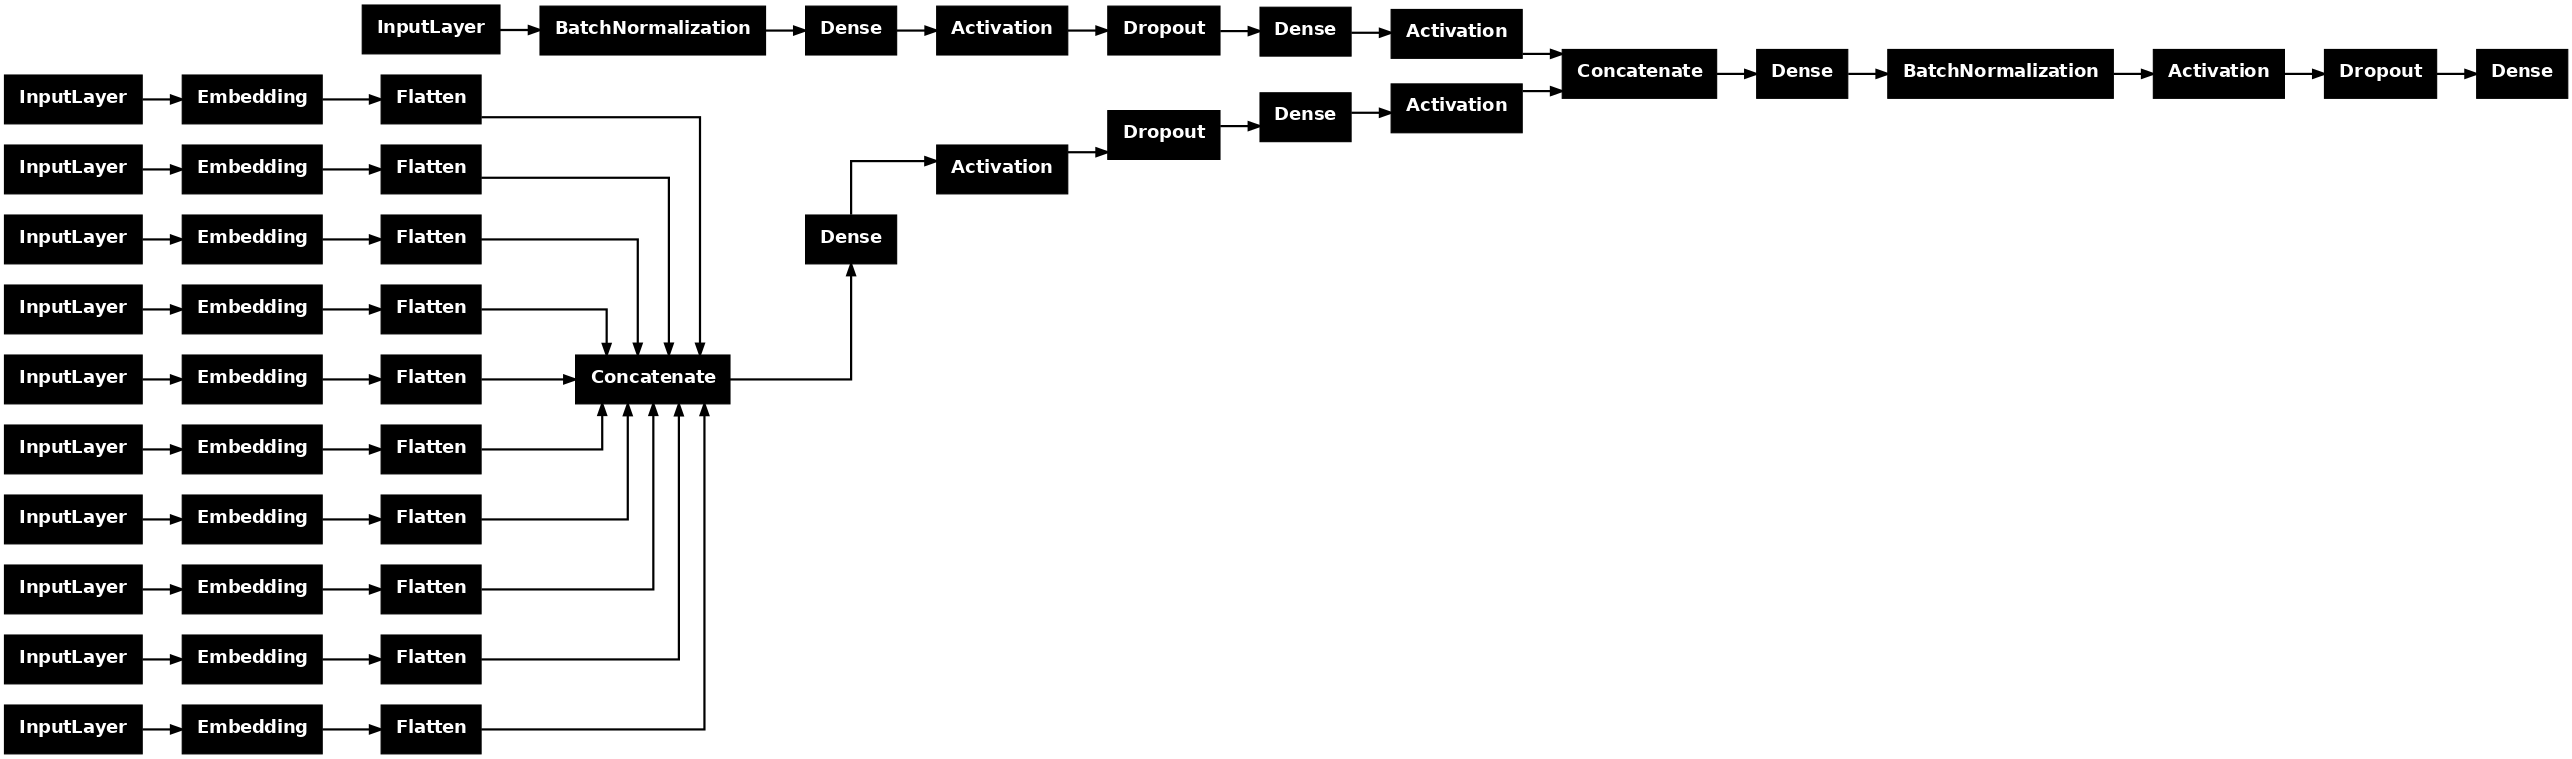

In [ ]:
model_view_plot = tf.keras.utils.plot_model(model_view, show_shapes=False, dpi=80, expand_nested=False, rankdir='LR')
model_view_plot

In [8]:
tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

metrics = {
    'roc_auc': [], 'pr_auc': [], 'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'conf_mat': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
    print(f"\n--- Fold {fold} ---")
    
    # Separar dados numéricos
    X_num_train_raw = X_numerical_df.iloc[train_idx].values
    X_num_val_raw = X_numerical_df.iloc[val_idx].values
    y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

    # Separar os dados categóricos
    X_cat_train = X_categorical_df.iloc[train_idx]
    X_cat_val = X_categorical_df.iloc[val_idx]

    # Fit scaler apenas no treino (evita data leakage)
    scaler_fold = MinMaxScaler()
    X_num_train = scaler_fold.fit_transform(X_num_train_raw)
    X_num_val = scaler_fold.transform(X_num_val_raw)
    
    # Calcular alpha balanceado por fold
    class_counts_fold = pd.Series(y_train).value_counts().sort_index()
    alpha_fold = class_counts_fold[0] / len(y_train)
    
    # Calcular class weights por fold (não global)
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_fold = dict(enumerate(class_weights_values))
    print(f"Class weights para fold {fold}: {class_weight_fold}")
    print(f"Alpha focal loss: {alpha_fold:.4f}")

    # Modelo paralelo com configuração padrão
    model = build_parallel_mlp(
        n_numeric=X_num_train.shape[1],
        categorical_cardinalities=categorical_cardinalities,
        numeric_layers=[128, 64],
        categorical_layers=[64, 32],
        merged_layers=[128],
        activation='relu',
        lr=1e-3,
        l2_reg=1e-5,
        dropout_rate=0.3,
        focal_gamma=2.0,
        focal_alpha=alpha_fold
    )

    # Preparar inputs para o modelo (separados)
    X_train_inputs = [X_num_train] + [X_cat_train[col].values.reshape(-1, 1) for col in X_cat_train.columns]
    X_val_inputs = [X_num_val] + [X_cat_val[col].values.reshape(-1, 1) for col in X_cat_val.columns]

    # Callbacks
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f'./models/parallel_mlp_fold{fold}.keras',
        monitor='val_pr_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=6, mode='max', verbose=0)

    model.fit(
        X_train_inputs, y_train,
        validation_data=(X_val_inputs, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weight_fold,
        callbacks=[es, rl, model_checkpoint],
        verbose=0
    )

    # Previsões e métricas
    y_pred_prob = model.predict(X_val_inputs, verbose=0).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_pred_prob)
    pr = average_precision_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print(f"ROC-AUC: {roc:.4f}  PR-AUC: {pr:.4f}  F1: {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  Acc: {acc:.4f}")
    print("Conf matrix:\n", cm)

    metrics['roc_auc'].append(roc)
    metrics['pr_auc'].append(pr)
    metrics['f1'].append(f1)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['accuracy'].append(acc)
    metrics['conf_mat'].append(cm)
    
    tf.keras.backend.clear_session()


--- Fold 1 ---
Class weights para fold 1: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175


2025-11-07 22:28:17.582802: I external/local_xla/xla/service/service.cc:163] XLA service 0x77afb0018b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-07 22:28:17.582827: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-07 22:28:17.701606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-07 22:28:18.098899: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-11-07 22:28:18.291216: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:28:18.

ROC-AUC: 0.9762  PR-AUC: 0.8073  F1: 0.6667  Prec: 0.5652  Rec: 0.8125  Acc: 0.9350
Conf matrix:
 [[174  10]
 [  3  13]]

--- Fold 2 ---
Class weights para fold 2: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175
ROC-AUC: 0.9800  PR-AUC: 0.8651  F1: 0.6122  Prec: 0.4545  Rec: 0.9375  Acc: 0.9050
Conf matrix:
 [[166  18]
 [  1  15]]
ROC-AUC: 0.9800  PR-AUC: 0.8651  F1: 0.6122  Prec: 0.4545  Rec: 0.9375  Acc: 0.9050
Conf matrix:
 [[166  18]
 [  1  15]]

--- Fold 3 ---
Class weights para fold 3: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175

--- Fold 3 ---
Class weights para fold 3: {0: 0.5449591280653951, 1: 6.0606060606060606}
Alpha focal loss: 0.9175
ROC-AUC: 0.9344  PR-AUC: 0.8123  F1: 0.7742  Prec: 0.8000  Rec: 0.7500  Acc: 0.9650
Conf matrix:
 [[181   3]
 [  4  12]]
ROC-AUC: 0.9344  PR-AUC: 0.8123  F1: 0.7742  Prec: 0.8000  Rec: 0.7500  Acc: 0.9650
Conf matrix:
 [[181   3]
 [  4  12]]

--- Fold 4 ---
Class weights para fold 4: {0: 0.5

In [9]:
# Encontrar o melhor threshold de decisão baseado na curva Precision-Recall
prec, rec, thresholds = precision_recall_curve(y_val, y_pred_prob)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"\nMelhor threshold baseado na curva PR: {best_threshold:.4f} com F1: {best_f1:.4f}")


Melhor threshold baseado na curva PR: 0.4810 com F1: 0.7500


In [10]:
# Resumo dos resultados:
def mean_std(lst):
    return np.mean(lst), np.std(lst)

print("\n=== Resumo final (5-fold) ===")
for k in ['roc_auc','pr_auc','f1','precision','recall','accuracy']:
    m, s = mean_std(metrics[k])
    print(f"{k}: {m:.4f} ± {s:.4f}")

# opcional: imprimir somatório das confusion matrices
total_cm = sum(metrics['conf_mat'])
print("Total confusion matrix (soma folds):\n", total_cm)


=== Resumo final (5-fold) ===
roc_auc: 0.9688 ± 0.0178
pr_auc: 0.8527 ± 0.0388
f1: 0.6937 ± 0.0538
precision: 0.6066 ± 0.1131
recall: 0.8412 ± 0.0639
accuracy: 0.9370 ± 0.0194
Total confusion matrix (soma folds):
 [[868  50]
 [ 13  69]]


---

## 4. Otimização de Hiperparâmetros com Optuna

Vamos usar o Optuna para encontrar a melhor combinação de:
- Número de camadas e neurônios para ramo numérico
- Número de camadas e neurônios para ramo categórico
- Número de camadas e neurônios para camadas após fusão
- Função de ativação
- Learning rate
- Regularização L2
- Dropout
- Parâmetros da Focal Loss (gamma e alpha)

**Métrica de otimização:** PR-AUC (Precision-Recall Area Under Curve)
- PR-AUC é mais adequada para datasets desbalanceados
- Foca na performance na classe minoritária (Optimal)
- Mais sensível a melhorias na detecção da classe positiva

**Estratégia de Pruning:** MedianPruner
- Interrompe trials que apresentam resultados intermediários ruins
- Economiza tempo computacional focando em configurações promissoras
- Permite avaliar mais configurações no mesmo tempo
- Pruning ocorre durante o treinamento (por época) e entre folds do CV

In [11]:
# Função objetivo para o Optuna com Pruning
def objective(trial):
    # Hiperparâmetros a serem otimizados
    
    # Arquitetura do ramo numérico
    n_numeric_layers = trial.suggest_int('n_numeric_layers', 2, 4)
    numeric_layers = [trial.suggest_int(f'numeric_units_l{i}', 32, 256, step=32) for i in range(n_numeric_layers)]
    
    # Arquitetura do ramo categórico
    n_categorical_layers = trial.suggest_int('n_categorical_layers', 1, 3)
    categorical_layers = [trial.suggest_int(f'categorical_units_l{i}', 16, 128, step=16) for i in range(n_categorical_layers)]
    
    # Arquitetura das camadas após fusão
    n_merged_layers = trial.suggest_int('n_merged_layers', 1, 3)
    merged_layers = [trial.suggest_int(f'merged_units_l{i}', 32, 256, step=32) for i in range(n_merged_layers)]
    
    # Outros hiperparâmetros
    activation = trial.suggest_categorical('activation', ['relu', 'elu', 'selu'])
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    l2 = trial.suggest_float('l2', 1e-6, 1e-3, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    
    # Parâmetros da Focal Loss
    focal_gamma = trial.suggest_float('focal_gamma', 0.3, 3.0)
    # focal_alpha será calculado por fold baseado na distribuição das classes
    
    # Usar 3-fold para otimização (mais rápido que 5-fold)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    fold_pr_aucs = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
        # Separar dados numéricos
        X_num_train_raw = X_numerical_df.iloc[train_idx].values
        X_num_val_raw = X_numerical_df.iloc[val_idx].values
        y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

        # Separar os dados categóricos
        X_cat_train = X_categorical_df.iloc[train_idx]
        X_cat_val = X_categorical_df.iloc[val_idx]

        # Fit scaler apenas no treino
        scaler_fold = MinMaxScaler()
        X_num_train = scaler_fold.fit_transform(X_num_train_raw)
        X_num_val = scaler_fold.transform(X_num_val_raw)
        
        # Calcular alpha balanceado por fold
        class_counts_fold = pd.Series(y_train).value_counts().sort_index()
        alpha_fold = class_counts_fold[0] / len(y_train)
        
        # Calcular class weights por fold
        class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight_fold = dict(enumerate(class_weights_values))

        # Criar modelo com hiperparâmetros sugeridos
        model = build_parallel_mlp(
            n_numeric=X_num_train.shape[1],
            categorical_cardinalities=categorical_cardinalities,
            numeric_layers=numeric_layers,
            categorical_layers=categorical_layers,
            merged_layers=merged_layers,
            activation=activation,
            lr=lr,
            l2_reg=l2,
            dropout_rate=dropout,
            focal_gamma=focal_gamma,
            focal_alpha=alpha_fold
        )

        # Preparar inputs para o modelo
        X_train_inputs = [X_num_train] + [X_cat_train[col].values.reshape(-1, 1) for col in X_cat_train.columns]
        X_val_inputs = [X_num_val] + [X_cat_val[col].values.reshape(-1, 1) for col in X_cat_val.columns]

        # Callbacks (incluindo pruning do Optuna)
        model_checkpoint = callbacks.ModelCheckpoint(
            filepath=f'./models/optuna_parallel_trial{trial.number}_fold{fold}.keras',
            monitor='val_pr_auc',
            mode='max',
            save_best_only=True,
            verbose=0
        )
        pruning_callback = optuna.integration.TFKerasPruningCallback(trial, 'val_pr_auc')
        es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
        rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=5, mode='max', verbose=0)

        # Treinar
        history = model.fit(
            X_train_inputs, y_train,
            validation_data=(X_val_inputs, y_val),
            epochs=100,
            batch_size=batch_size,
            class_weight=class_weight_fold,
            callbacks=[es, rl, pruning_callback, model_checkpoint],
            verbose=0
        )

        # Avaliar usando PR-AUC
        y_pred_prob = model.predict(X_val_inputs, verbose=0).ravel()
        pr_auc = average_precision_score(y_val, y_pred_prob)
        fold_pr_aucs.append(pr_auc)
        
        # Reportar resultado intermediário para pruning entre folds
        intermediate_value = np.mean(fold_pr_aucs)
        trial.report(intermediate_value, fold)
        
        # Verificar se o trial deve ser podado
        if trial.should_prune():
            tf.keras.backend.clear_session()
            del model
            raise optuna.TrialPruned()
        
        # Limpar memória
        tf.keras.backend.clear_session()
        del model
    
    # Retornar média do PR-AUC nos 3 folds
    mean_pr_auc = np.mean(fold_pr_aucs)
    return mean_pr_auc

In [12]:
# Criar e executar o estudo Optuna com Pruning
print("Iniciando otimização de hiperparâmetros com Optuna...")
print("Modelo: MLP Paralelo (ramos separados para variáveis numéricas e categóricas)")
print("Usando MedianPruner para interromper trials não promissores")
print("Isso pode levar algum tempo...\n")

# MedianPruner: poda trials cujo valor intermediário é pior que a mediana dos trials anteriores
pruner = optuna.pruners.MedianPruner(
    n_startup_trials=5,  # Número de trials completos antes de começar a podar
    n_warmup_steps=1,    # Número de steps (folds) antes de começar a podar dentro de um trial
    interval_steps=1     # Verificar a cada fold se deve podar
)

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_SEED),
    pruner=pruner,
    study_name='parallel_mlp_quantum_encryption'
)

# Executar otimização com 50 trials
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n=== Resultados da Otimização ===")
print(f"Melhor PR-AUC: {study.best_value:.4f}")
print(f"Trials completados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"\nMelhores hiperparâmetros:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-07 22:30:42,344] A new study created in memory with name: parallel_mlp_quantum_encryption


Iniciando otimização de hiperparâmetros com Optuna...
Modelo: MLP Paralelo (ramos separados para variáveis numéricas e categóricas)
Usando MedianPruner para interromper trials não promissores
Isso pode levar algum tempo...



  0%|          | 0/50 [00:00<?, ?it/s]2025-11-07 22:30:45.903123: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:30:45.903199: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:30:45.903235: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
20

[I 2025-11-07 22:31:42,968] Trial 0 finished with value: 0.8370660354538509 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 256, 'numeric_units_l1': 192, 'numeric_units_l2': 160, 'n_categorical_layers': 1, 'categorical_units_l0': 32, 'n_merged_layers': 1, 'merged_units_l0': 224, 'activation': 'elu', 'lr': 0.008123245085588688, 'l2': 0.0003142880890840109, 'dropout': 0.18493564427131048, 'batch_size': 64, 'focal_gamma': 1.7168423654070424}. Best is trial 0 with value: 0.8370660354538509.


2025-11-07 22:31:46.810979: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:31:46.811033: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:31:46.811052: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:31:46.811060: I external/l

[I 2025-11-07 22:33:00,450] Trial 1 finished with value: 0.8881947886162657 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 96, 'numeric_units_l1': 160, 'numeric_units_l2': 64, 'n_categorical_layers': 1, 'categorical_units_l0': 48, 'n_merged_layers': 2, 'merged_units_l0': 224, 'merged_units_l1': 64, 'activation': 'elu', 'lr': 0.0006647135865318024, 'l2': 3.247673570627449e-06, 'dropout': 0.12602063719411183, 'batch_size': 32, 'focal_gamma': 1.1224571767681009}. Best is trial 1 with value: 0.8881947886162657.


2025-11-07 22:33:18.694622: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:33:18.694687: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:33:18.962592: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_188', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:33:19.009436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

[I 2025-11-07 22:34:03,659] Trial 2 finished with value: 0.8510940896344374 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 192, 'numeric_units_l1': 128, 'n_categorical_layers': 1, 'categorical_units_l0': 64, 'n_merged_layers': 1, 'merged_units_l0': 256, 'activation': 'elu', 'lr': 0.00036324869566766035, 'l2': 4.366473592979636e-05, 'dropout': 0.17394178221021084, 'batch_size': 16, 'focal_gamma': 2.7160338461546516}. Best is trial 1 with value: 0.8881947886162657.


2025-11-07 22:34:08.113497: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:34:08.172535: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:34:12.521491: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3586', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:34:12.602554: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3336', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:34:12.521491: I external/local_x

[I 2025-11-07 22:35:44,088] Trial 3 finished with value: 0.8082430437393994 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 256, 'numeric_units_l1': 32, 'numeric_units_l2': 64, 'n_categorical_layers': 1, 'categorical_units_l0': 48, 'n_merged_layers': 2, 'merged_units_l0': 96, 'merged_units_l1': 224, 'activation': 'selu', 'lr': 2.6471141828218167e-05, 'l2': 0.0002550298070162893, 'dropout': 0.12982025747190834, 'batch_size': 16, 'focal_gamma': 0.3149097162337265}. Best is trial 1 with value: 0.8881947886162657.


2025-11-07 22:35:48.843540: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:35:48.843598: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:35:48.843624: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:35:48.843631: I external/l

[I 2025-11-07 22:37:09,086] Trial 4 finished with value: 0.8562281174204532 and parameters: {'n_numeric_layers': 4, 'numeric_units_l0': 192, 'numeric_units_l1': 192, 'numeric_units_l2': 224, 'numeric_units_l3': 32, 'n_categorical_layers': 2, 'categorical_units_l0': 16, 'categorical_units_l1': 112, 'n_merged_layers': 2, 'merged_units_l0': 96, 'merged_units_l1': 32, 'activation': 'selu', 'lr': 0.0008178476574339542, 'l2': 0.0004588156549160974, 'dropout': 0.28888597006477973, 'batch_size': 64, 'focal_gamma': 1.81544843343764}. Best is trial 1 with value: 0.8881947886162657.


2025-11-07 22:37:13.542097: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:37:13.542163: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:37:13.542172: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:37:13.542181: I external/l

[I 2025-11-07 22:37:34,101] Trial 5 pruned. Trial was pruned at epoch 1.


2025-11-07 22:37:44.158150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3855', 12 bytes spill stores, 12 bytes spill loads

Best trial: 1. Best value: 0.888195:  14%|█▍        | 7/50 [07:10<34:40, 48.39s/it]

[I 2025-11-07 22:37:53,187] Trial 6 pruned. Trial was pruned at epoch 3.


2025-11-07 22:37:59.426203: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:37:59.426263: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:37:59.426283: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:37:59.426291: I external/l

[I 2025-11-07 22:38:20,885] Trial 7 pruned. Trial was pruned at epoch 1.


2025-11-07 22:38:25.364522: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:38:25.364643: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:38:25.364655: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:38:25.364663: I external/l

[I 2025-11-07 22:38:39,498] Trial 8 pruned. Trial was pruned at epoch 3.


2025-11-07 22:38:45.346595: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:38:45.346654: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:38:45.346675: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:38:45.346682: I external/l

[I 2025-11-07 22:39:04,177] Trial 9 pruned. Trial was pruned at epoch 1.


2025-11-07 22:39:10.539176: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:10.539223: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:10.539236: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:10.539243: I external/l

[I 2025-11-07 22:39:28,640] Trial 10 pruned. Trial was pruned at epoch 1.


2025-11-07 22:39:34.457573: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:34.457714: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:34.457787: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:34.457801: I external/l

[I 2025-11-07 22:39:51,484] Trial 11 pruned. Trial was pruned at epoch 1.


2025-11-07 22:39:58.387275: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:58.387340: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:58.387364: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:39:58.387374: I external/l

[I 2025-11-07 22:40:26,796] Trial 12 pruned. Trial was pruned at epoch 1.


2025-11-07 22:40:31.507751: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:40:31.507822: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:40:31.507834: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:40:31.507848: I external/l

[I 2025-11-07 22:40:47,005] Trial 13 pruned. Trial was pruned at epoch 1.


2025-11-07 22:40:52.482812: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:40:52.482949: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:40:52.482963: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:40:52.482973: I external/l

[I 2025-11-07 22:41:10,437] Trial 14 pruned. Trial was pruned at epoch 1.


2025-11-07 22:41:15.201196: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:41:15.201266: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:41:15.201277: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:41:15.201285: I external/l

[I 2025-11-07 22:41:33,326] Trial 15 pruned. Trial was pruned at epoch 2.


2025-11-07 22:41:39.113046: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:41:39.113115: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:41:39.113146: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:41:39.113154: I external/l

[I 2025-11-07 22:41:59,725] Trial 16 pruned. Trial was pruned at epoch 1.


Best trial: 1. Best value: 0.888195:  36%|███▌      | 18/50 [11:30<11:34, 21.72s/it]

[I 2025-11-07 22:42:12,893] Trial 17 pruned. Trial was pruned at epoch 3.


2025-11-07 22:42:17.774829: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:42:17.774911: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:42:17.774924: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:42:17.774948: I external/l

[I 2025-11-07 22:42:31,966] Trial 18 pruned. Trial was pruned at epoch 2.


2025-11-07 22:42:37.370349: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4973', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:42:37.386340: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3601', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:42:37.727001: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3601', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:42:37.727001: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3601', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:42:44.022739: I external/local_xla

[I 2025-11-07 22:42:52,994] Trial 19 pruned. Trial was pruned at epoch 1.


2025-11-07 22:42:58.494452: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:42:58.494510: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:42:58.494524: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:42:58.494560: I external/l

[I 2025-11-07 22:43:12,994] Trial 20 pruned. Trial was pruned at epoch 1.


Best trial: 1. Best value: 0.888195:  44%|████▍     | 22/50 [12:41<08:13, 17.61s/it]

[I 2025-11-07 22:43:23,485] Trial 21 pruned. Trial was pruned at epoch 2.


Best trial: 1. Best value: 0.888195:  46%|████▌     | 23/50 [12:52<07:02, 15.66s/it]

[I 2025-11-07 22:43:34,596] Trial 22 pruned. Trial was pruned at epoch 1.


Best trial: 1. Best value: 0.888195:  48%|████▊     | 24/50 [13:03<06:11, 14.29s/it]

[I 2025-11-07 22:43:45,695] Trial 23 pruned. Trial was pruned at epoch 2.


Best trial: 1. Best value: 0.888195:  50%|█████     | 25/50 [13:14<05:33, 13.34s/it]

[I 2025-11-07 22:43:56,809] Trial 24 pruned. Trial was pruned at epoch 1.


2025-11-07 22:44:01.771621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2417', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:44:06.123460: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3451', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:44:06.151150: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3297', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:44:06.123460: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3451', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:44:06.151150: I external/local

[I 2025-11-07 22:44:16,027] Trial 25 pruned. Trial was pruned at epoch 10.


2025-11-07 22:44:22.041651: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:44:22.041711: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:44:22.041722: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:44:22.041731: I external/l

[I 2025-11-07 22:44:42,040] Trial 26 pruned. Trial was pruned at epoch 2.


2025-11-07 22:44:51.184951: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4004', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:44:51.301833: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3754', 8 bytes spill stores, 8 bytes spill loads

Best trial: 1. Best value: 0.888195:  56%|█████▌    | 28/50 [14:15<06:29, 17.69s/it]

[I 2025-11-07 22:44:58,114] Trial 27 pruned. Trial was pruned at epoch 1.


2025-11-07 22:45:01.482348: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:45:01.482436: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:45:02.177910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3350', 768 bytes spill stores, 768 bytes spill loads

2025-11-07 22:45:02.177910: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning

[I 2025-11-07 22:45:10,979] Trial 28 pruned. Trial was pruned at epoch 1.


2025-11-07 22:45:15.424109: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:45:16.102115: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 68 bytes spill stores, 68 bytes spill loads

2025-11-07 22:45:16.102115: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 68 bytes spill stores, 68 bytes spill loads

/home/denysderlian/anaconda3/envs/NNenv/lib/python3.11/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(


[I 2025-11-07 22:46:19,636] Trial 29 finished with value: 0.8617153347473816 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 256, 'numeric_units_l1': 96, 'numeric_units_l2': 224, 'n_categorical_layers': 1, 'categorical_units_l0': 32, 'n_merged_layers': 1, 'merged_units_l0': 224, 'activation': 'elu', 'lr': 0.0052708120693676945, 'l2': 0.00047837055744880255, 'dropout': 0.14580344052466324, 'batch_size': 32, 'focal_gamma': 1.9169664178385002}. Best is trial 1 with value: 0.8881947886162657.


2025-11-07 22:46:24.725209: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:46:24.725271: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:46:24.725335: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:46:24.725344: I external/l

[I 2025-11-07 22:47:17,271] Trial 30 pruned. Trial was pruned at epoch 29.


2025-11-07 22:47:20.762409: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:47:21.319338: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 20 bytes spill stores, 20 bytes spill loads

2025-11-07 22:47:21.385850: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:47:21.476946: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 272 b

[I 2025-11-07 22:47:31,235] Trial 31 pruned. Trial was pruned at epoch 4.


2025-11-07 22:47:35.886347: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:47:36.392919: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:47:36.435660: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 44 bytes spill stores, 44 bytes spill loads

2025-11-07 22:47:36.513023: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 288 byt

[I 2025-11-07 22:47:45,747] Trial 32 pruned. Trial was pruned at epoch 1.


2025-11-07 22:47:49.511820: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:47:49.511889: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:47:49.511901: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:47:49.511910: I external/l

[I 2025-11-07 22:49:03,645] Trial 33 finished with value: 0.9099255710369031 and parameters: {'n_numeric_layers': 3, 'numeric_units_l0': 224, 'numeric_units_l1': 128, 'numeric_units_l2': 160, 'n_categorical_layers': 1, 'categorical_units_l0': 48, 'n_merged_layers': 1, 'merged_units_l0': 192, 'activation': 'elu', 'lr': 0.001127977413270461, 'l2': 0.00023842901402086806, 'dropout': 0.14145988860641567, 'batch_size': 32, 'focal_gamma': 1.616418885072247}. Best is trial 33 with value: 0.9099255710369031.


Best trial: 33. Best value: 0.909926:  70%|███████   | 35/50 [18:34<08:22, 33.48s/it]

[I 2025-11-07 22:49:17,081] Trial 34 pruned. Trial was pruned at epoch 4.


2025-11-07 22:49:20.592055: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:20.592118: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:21.330935: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3380', 8 bytes spill stores, 8 bytes spill loads

2025-11-07 22:49:21.386898: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

[I 2025-11-07 22:49:30,659] Trial 35 pruned. Trial was pruned at epoch 2.


2025-11-07 22:49:36.110024: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:36.110085: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:36.110092: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:36.110102: I external/l

[I 2025-11-07 22:49:53,287] Trial 36 pruned. Trial was pruned at epoch 1.


2025-11-07 22:49:57.582724: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:57.582778: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:57.582788: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:49:58.714710: I external/l

[I 2025-11-07 22:50:10,614] Trial 37 pruned. Trial was pruned at epoch 4.


2025-11-07 22:50:16.175788: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:50:16.175877: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:50:16.175894: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:50:16.175907: I external/l

[I 2025-11-07 22:50:31,457] Trial 38 pruned. Trial was pruned at epoch 1.


2025-11-07 22:50:35.962760: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:50:35.962815: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:50:35.962847: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:50:35.962853: I external/l

[I 2025-11-07 22:50:55,000] Trial 39 pruned. Trial was pruned at epoch 4.


2025-11-07 22:51:00.025272: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:00.026040: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:00.026060: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:00.026071: I external/l

[I 2025-11-07 22:51:12,215] Trial 40 pruned. Trial was pruned at epoch 1.


2025-11-07 22:51:16.901011: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2281', 12 bytes spill stores, 12 bytes spill loads

Best trial: 33. Best value: 0.909926:  84%|████████▍ | 42/50 [20:46<02:37, 19.74s/it]

[I 2025-11-07 22:51:28,543] Trial 41 pruned. Trial was pruned at epoch 2.


2025-11-07 22:51:33.701495: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:33.701556: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:33.701568: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:34.882338: I external/l

[I 2025-11-07 22:51:44,444] Trial 42 pruned. Trial was pruned at epoch 1.


2025-11-07 22:51:48.660471: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:48.660528: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:48.660541: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:51:48.660552: I external/l

[I 2025-11-07 22:52:02,076] Trial 43 pruned. Trial was pruned at epoch 2.


2025-11-07 22:52:06.645075: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:52:06.645179: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:52:06.645191: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:52:06.645205: I external/l

[I 2025-11-07 22:52:20,636] Trial 44 pruned. Trial was pruned at epoch 1.


2025-11-07 22:52:25.760435: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:52:25.760507: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:52:25.760522: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:52:25.760533: I external/l

[I 2025-11-07 22:52:40,897] Trial 45 pruned. Trial was pruned at epoch 1.


2025-11-07 22:53:05.380229: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:53:05.565768: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 4 bytes spill stores, 4 bytes spill loads

2025-11-07 22:53:05.954792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 4 bytes spill stores, 4 bytes spill loads

2025-11-07 22:53:05.954792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_222', 4 bytes spil

[I 2025-11-07 22:53:57,321] Trial 46 finished with value: 0.8593487562367933 and parameters: {'n_numeric_layers': 2, 'numeric_units_l0': 224, 'numeric_units_l1': 224, 'n_categorical_layers': 2, 'categorical_units_l0': 32, 'categorical_units_l1': 128, 'n_merged_layers': 2, 'merged_units_l0': 32, 'merged_units_l1': 32, 'activation': 'elu', 'lr': 0.0008411013444704908, 'l2': 1.4881364083154877e-06, 'dropout': 0.49743822068735133, 'batch_size': 16, 'focal_gamma': 2.1694189290581436}. Best is trial 33 with value: 0.9099255710369031.


2025-11-07 22:54:02.556829: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:54:02.796934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2833', 4 bytes spill stores, 4 bytes spill loads

2025-11-07 22:54:02.996204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2833', 12 bytes spill stores, 12 bytes spill loads

2025-11-07 22:54:02.796934: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2833', 4 bytes

[I 2025-11-07 22:54:15,319] Trial 47 pruned. Trial was pruned at epoch 2.


2025-11-07 22:54:19.954429: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:54:19.954525: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-07 22:54:21.227822: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3554', 44 bytes spill stores, 44 bytes spill loads

2025-11-07 22:54:21.227822: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

[I 2025-11-07 22:54:32,708] Trial 48 pruned. Trial was pruned at epoch 1.


Best trial: 33. Best value: 0.909926: 100%|██████████| 50/50 [24:09<00:00, 28.99s/it]

[I 2025-11-07 22:54:51,692] Trial 49 pruned. Trial was pruned at epoch 1.

=== Resultados da Otimização ===
Melhor PR-AUC: 0.9099
Trials completados: 8
Trials podados: 42

Melhores hiperparâmetros:
  n_numeric_layers: 3
  numeric_units_l0: 224
  numeric_units_l1: 128
  numeric_units_l2: 160
  n_categorical_layers: 1
  categorical_units_l0: 48
  n_merged_layers: 1
  merged_units_l0: 192
  activation: elu
  lr: 0.001127977413270461
  l2: 0.00023842901402086806
  dropout: 0.14145988860641567
  batch_size: 32
  focal_gamma: 1.616418885072247


In [13]:
# Visualizar histórico de otimização
fig_history = plot_optimization_history(study)
fig_history.update_layout(title="Histórico de Otimização - PR-AUC ao longo dos trials")
fig_history.show()

In [14]:
# Visualizar importância dos hiperparâmetros
fig_importance = plot_param_importances(study)
fig_importance.update_layout(title="Importância dos Hiperparâmetros")
fig_importance.show()

In [15]:
# Reconstruir a arquitetura otimizada
best_params = study.best_params

# Extrair configuração das camadas
n_numeric_layers = best_params['n_numeric_layers']
best_numeric_layers = [best_params[f'numeric_units_l{i}'] for i in range(n_numeric_layers)]

n_categorical_layers = best_params['n_categorical_layers']
best_categorical_layers = [best_params[f'categorical_units_l{i}'] for i in range(n_categorical_layers)]

n_merged_layers = best_params['n_merged_layers']
best_merged_layers = [best_params[f'merged_units_l{i}'] for i in range(n_merged_layers)]

print("=== Arquitetura Otimizada ===")
print(f"\nRamo Numérico ({n_numeric_layers} camadas):")
for i, units in enumerate(best_numeric_layers):
    print(f"  Camada {i+1}: {units} neurônios")

print(f"\nRamo Categórico ({n_categorical_layers} camadas após embeddings):")
for i, units in enumerate(best_categorical_layers):
    print(f"  Camada {i+1}: {units} neurônios")

print(f"\nCamadas após Fusão ({n_merged_layers} camadas):")
for i, units in enumerate(best_merged_layers):
    print(f"  Camada {i+1}: {units} neurônios")

print(f"\nOutros Parâmetros:")
print(f"  Ativação: {best_params['activation']}")
print(f"  Learning rate: {best_params['lr']:.6f}")
print(f"  L2 regularization: {best_params['l2']:.6f}")
print(f"  Dropout: {best_params['dropout']:.3f}")
print(f"  Batch size: {best_params['batch_size']}")
print(f"  Focal Loss Gamma: {best_params['focal_gamma']:.2f}")

=== Arquitetura Otimizada ===

Ramo Numérico (3 camadas):
  Camada 1: 224 neurônios
  Camada 2: 128 neurônios
  Camada 3: 160 neurônios

Ramo Categórico (1 camadas após embeddings):
  Camada 1: 48 neurônios

Camadas após Fusão (1 camadas):
  Camada 1: 192 neurônios

Outros Parâmetros:
  Ativação: elu
  Learning rate: 0.001128
  L2 regularization: 0.000238
  Dropout: 0.141
  Batch size: 32
  Focal Loss Gamma: 1.62


In [16]:
# Avaliar modelo otimizado com 5-fold CV
print("=== Avaliação do Modelo Paralelo Otimizado com 5-fold CV ===\n")

tf.keras.backend.clear_session()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

optimized_metrics = {
    'roc_auc': [], 'pr_auc': [], 'f1': [], 'precision': [], 'recall': [], 'accuracy': [], 'conf_mat': []
}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_numerical_df, y), 1):
    print(f"--- Fold {fold} ---")
    
    # Separar dados numéricos
    X_num_train_raw = X_numerical_df.iloc[train_idx].values
    X_num_val_raw = X_numerical_df.iloc[val_idx].values
    y_train, y_val = y.iloc[train_idx].values.ravel(), y.iloc[val_idx].values.ravel()

    # Separar os dados categóricos
    X_cat_train = X_categorical_df.iloc[train_idx]
    X_cat_val = X_categorical_df.iloc[val_idx]

    # Fit scaler apenas no treino
    scaler_fold = MinMaxScaler()
    X_num_train = scaler_fold.fit_transform(X_num_train_raw)
    X_num_val = scaler_fold.transform(X_num_val_raw)
    
    # Calcular alpha balanceado por fold
    class_counts_fold = pd.Series(y_train).value_counts().sort_index()
    alpha_fold = class_counts_fold[0] / len(y_train)
    
    # Calcular class weights por fold
    class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight_fold = dict(enumerate(class_weights_values))

    # Modelo otimizado
    model = build_parallel_mlp(
        n_numeric=X_num_train.shape[1],
        categorical_cardinalities=categorical_cardinalities,
        numeric_layers=best_numeric_layers,
        categorical_layers=best_categorical_layers,
        merged_layers=best_merged_layers,
        activation=best_params['activation'],
        lr=best_params['lr'],
        l2_reg=best_params['l2'],
        dropout_rate=best_params['dropout'],
        focal_gamma=best_params['focal_gamma'],
        focal_alpha=alpha_fold
    )

    # Preparar inputs para o modelo
    X_train_inputs = [X_num_train] + [X_cat_train[col].values.reshape(-1, 1) for col in X_cat_train.columns]
    X_val_inputs = [X_num_val] + [X_cat_val[col].values.reshape(-1, 1) for col in X_cat_val.columns]

    # Callbacks
    model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f'./models/optimized_parallel_mlp_fold{fold}.keras',
        monitor='val_pr_auc',
        mode='max',
        save_best_only=True,
        verbose=0
    )
    es = callbacks.EarlyStopping(monitor='val_pr_auc', patience=10, mode='max', restore_best_weights=True, verbose=0)
    rl = callbacks.ReduceLROnPlateau(monitor='val_pr_auc', factor=0.5, patience=6, mode='max', verbose=0)

    model.fit(
        X_train_inputs, y_train,
        validation_data=(X_val_inputs, y_val),
        epochs=100,
        batch_size=best_params['batch_size'],
        class_weight=class_weight_fold,
        callbacks=[es, rl, model_checkpoint],
        verbose=0
    )

    # Previsões e métricas
    y_pred_prob = model.predict(X_val_inputs, verbose=0).ravel()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    roc = roc_auc_score(y_val, y_pred_prob)
    pr = average_precision_score(y_val, y_pred_prob)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    print(f"ROC-AUC: {roc:.4f}  PR-AUC: {pr:.4f}  F1: {f1:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  Acc: {acc:.4f}")
    print("Conf matrix:\n", cm)

    optimized_metrics['roc_auc'].append(roc)
    optimized_metrics['pr_auc'].append(pr)
    optimized_metrics['f1'].append(f1)
    optimized_metrics['precision'].append(prec)
    optimized_metrics['recall'].append(rec)
    optimized_metrics['accuracy'].append(acc)
    optimized_metrics['conf_mat'].append(cm)
    
    tf.keras.backend.clear_session()

print("\n=== Resumo Final do Modelo Paralelo Otimizado (5-fold CV) ===")
for k in ['roc_auc','pr_auc','f1','precision','recall','accuracy']:
    m, s = np.mean(optimized_metrics[k]), np.std(optimized_metrics[k])
    print(f"{k}: {m:.4f} ± {s:.4f}")

total_cm_optimized = sum(optimized_metrics['conf_mat'])
print("\nTotal confusion matrix (soma dos 5 folds):\n", total_cm_optimized)

=== Avaliação do Modelo Paralelo Otimizado com 5-fold CV ===

--- Fold 1 ---
--- Fold 1 ---
ROC-AUC: 0.9922  PR-AUC: 0.9233  F1: 0.8333  Prec: 0.7500  Rec: 0.9375  Acc: 0.9700
Conf matrix:
 [[179   5]
 [  1  15]]
ROC-AUC: 0.9922  PR-AUC: 0.9233  F1: 0.8333  Prec: 0.7500  Rec: 0.9375  Acc: 0.9700
Conf matrix:
 [[179   5]
 [  1  15]]
--- Fold 2 ---
--- Fold 2 ---
ROC-AUC: 0.9827  PR-AUC: 0.8704  F1: 0.6829  Prec: 0.5600  Rec: 0.8750  Acc: 0.9350
Conf matrix:
 [[173  11]
 [  2  14]]
ROC-AUC: 0.9827  PR-AUC: 0.8704  F1: 0.6829  Prec: 0.5600  Rec: 0.8750  Acc: 0.9350
Conf matrix:
 [[173  11]
 [  2  14]]
--- Fold 3 ---
--- Fold 3 ---
ROC-AUC: 0.9969  PR-AUC: 0.9678  F1: 0.7857  Prec: 0.9167  Rec: 0.6875  Acc: 0.9700
Conf matrix:
 [[183   1]
 [  5  11]]
ROC-AUC: 0.9969  PR-AUC: 0.9678  F1: 0.7857  Prec: 0.9167  Rec: 0.6875  Acc: 0.9700
Conf matrix:
 [[183   1]
 [  5  11]]
--- Fold 4 ---
--- Fold 4 ---
ROC-AUC: 0.9913  PR-AUC: 0.9503  F1: 0.8108  Prec: 0.7500  Rec: 0.8824  Acc: 0.9650
Conf mat

In [17]:
# Encontrar o fold com melhor PR-AUC
best_fold_idx = np.argmax(optimized_metrics['pr_auc'])
best_fold_number = int(best_fold_idx + 1)

print(f"\n=== Melhor Modelo Paralelo Otimizado ===")
print(f"Fold: {best_fold_number}")
print(f"PR-AUC: {optimized_metrics['pr_auc'][best_fold_idx]:.4f}")
print(f"ROC-AUC: {optimized_metrics['roc_auc'][best_fold_idx]:.4f}")
print(f"F1-Score: {optimized_metrics['f1'][best_fold_idx]:.4f}")
print(f"Precision: {optimized_metrics['precision'][best_fold_idx]:.4f}")
print(f"Recall: {optimized_metrics['recall'][best_fold_idx]:.4f}")
print(f"Accuracy: {optimized_metrics['accuracy'][best_fold_idx]:.4f}")

# Copiar o melhor modelo para um arquivo final
best_model_path = f'./models/optimized_parallel_mlp_fold{best_fold_number}.keras'
final_model_path = './models/best_optimized_parallel_mlp.keras'
shutil.copy(best_model_path, final_model_path)
print(f"\nMelhor modelo salvo em: {final_model_path}")

# Salvar informações do melhor modelo em JSON
best_model_info = {
    'model_type': 'Parallel_MLP_Optimized',
    'best_fold': best_fold_number,
    'architecture': {
        'numeric_branch': {
            'n_layers': len(best_numeric_layers),
            'layers': best_numeric_layers
        },
        'categorical_branch': {
            'n_layers': len(best_categorical_layers),
            'layers': best_categorical_layers
        },
        'merged_branch': {
            'n_layers': len(best_merged_layers),
            'layers': best_merged_layers
        },
        'activation': best_params['activation'],
        'n_numeric_features': len(NUMERICAL_COLUMNS),
        'categorical_cardinalities': categorical_cardinalities
    },
    'hyperparameters': {
        'lr': float(best_params['lr']),
        'l2': float(best_params['l2']),
        'dropout': float(best_params['dropout']),
        'batch_size': int(best_params['batch_size']),
        'focal_gamma': float(best_params['focal_gamma'])
    },
    'metrics': {
        'pr_auc': float(optimized_metrics['pr_auc'][best_fold_idx]),
        'roc_auc': float(optimized_metrics['roc_auc'][best_fold_idx]),
        'f1_score': float(optimized_metrics['f1'][best_fold_idx]),
        'precision': float(optimized_metrics['precision'][best_fold_idx]),
        'recall': float(optimized_metrics['recall'][best_fold_idx]),
        'accuracy': float(optimized_metrics['accuracy'][best_fold_idx])
    },
    'cv_metrics_mean': {
        'pr_auc': float(np.mean(optimized_metrics['pr_auc'])),
        'roc_auc': float(np.mean(optimized_metrics['roc_auc'])),
        'f1_score': float(np.mean(optimized_metrics['f1'])),
        'precision': float(np.mean(optimized_metrics['precision'])),
        'recall': float(np.mean(optimized_metrics['recall'])),
        'accuracy': float(np.mean(optimized_metrics['accuracy']))
    },
    'cv_metrics_std': {
        'pr_auc': float(np.std(optimized_metrics['pr_auc'])),
        'roc_auc': float(np.std(optimized_metrics['roc_auc'])),
        'f1_score': float(np.std(optimized_metrics['f1'])),
        'precision': float(np.std(optimized_metrics['precision'])),
        'recall': float(np.std(optimized_metrics['recall'])),
        'accuracy': float(np.std(optimized_metrics['accuracy']))
    }
}

with open('./models/best_optimized_parallel_mlp_info.json', 'w') as f:
    json.dump(best_model_info, f, indent=4)

print("Informações do modelo salvas em: ./models/best_optimized_parallel_mlp_info.json")


=== Melhor Modelo Paralelo Otimizado ===
Fold: 3
PR-AUC: 0.9678
ROC-AUC: 0.9969
F1-Score: 0.7857
Precision: 0.9167
Recall: 0.6875
Accuracy: 0.9700

Melhor modelo salvo em: ./models/best_optimized_parallel_mlp.keras
Informações do modelo salvas em: ./models/best_optimized_parallel_mlp_info.json


In [18]:
models_dir = Path('./models')
print("=== Modelos Salvos ===\n")

# Listar modelos baseline paralelos
baseline_models = sorted(models_dir.glob('parallel_mlp_fold*.keras'))
print("Modelos Baseline (Paralelo):")
for model_path in baseline_models:
    size_mb = model_path.stat().st_size / (1024 * 1024)
    print(f"  - {model_path.name} ({size_mb:.2f} MB)")

# Listar modelos otimizados
print("\nModelos Paralelos Otimizados (5-fold CV):")
optimized_models = sorted(models_dir.glob('optimized_parallel_mlp_fold*.keras'))
for model_path in optimized_models:
    size_mb = model_path.stat().st_size / (1024 * 1024)
    print(f"  - {model_path.name} ({size_mb:.2f} MB)")

# Modelo final
print("\nModelo Final:")
final_model = models_dir / 'best_optimized_parallel_mlp.keras'
if final_model.exists():
    size_mb = final_model.stat().st_size / (1024 * 1024)
    print(f"  - {final_model.name} ({size_mb:.2f} MB)")
    print(f"  - Informações: best_optimized_parallel_mlp_info.json")

# Contar modelos do Optuna (apenas para referência, podem ser muitos)
optuna_models = list(models_dir.glob('optuna_parallel_trial*.keras'))
if optuna_models:
    print(f"\nModelos de trials do Optuna: {len(optuna_models)} arquivos")
    total_size = sum(m.stat().st_size for m in optuna_models) / (1024 * 1024)
    print(f"  Espaço total: {total_size:.2f} MB")

=== Modelos Salvos ===

Modelos Baseline (Paralelo):
  - parallel_mlp_fold1.keras (0.47 MB)
  - parallel_mlp_fold2.keras (0.47 MB)
  - parallel_mlp_fold3.keras (0.47 MB)
  - parallel_mlp_fold4.keras (0.47 MB)
  - parallel_mlp_fold5.keras (0.47 MB)

Modelos Paralelos Otimizados (5-fold CV):
  - optimized_parallel_mlp_fold1.keras (1.26 MB)
  - optimized_parallel_mlp_fold2.keras (1.26 MB)
  - optimized_parallel_mlp_fold3.keras (1.26 MB)
  - optimized_parallel_mlp_fold4.keras (1.26 MB)
  - optimized_parallel_mlp_fold5.keras (1.26 MB)

Modelo Final:
  - best_optimized_parallel_mlp.keras (1.26 MB)
  - Informações: best_optimized_parallel_mlp_info.json

Modelos de trials do Optuna: 67 arquivos
  Espaço total: 87.64 MB


---

## 5. Carregar e Usar o Melhor Modelo

Exemplo de como carregar o melhor modelo salvo e fazer predições:

In [19]:
# Carregar o melhor modelo
# Nota: Para carregar o modelo, precisamos registrar a função de loss customizada
custom_objects = {'loss_fn': binary_focal_loss(gamma=2.0, alpha=0.25)}
best_model = tf.keras.models.load_model('./models/best_optimized_parallel_mlp.keras', custom_objects=custom_objects)

# Carregar informações do modelo
with open('./models/best_optimized_parallel_mlp_info.json', 'r') as f:
    model_info = json.load(f)

print("=== Informações do Melhor Modelo ===")
print(f"Tipo: {model_info['model_type']}")
print(f"Fold: {model_info['best_fold']}")
print(f"\nArquitetura:")
print(f"  Ramo Numérico:")
print(f"    Camadas: {model_info['architecture']['numeric_branch']['layers']}")
print(f"  Ramo Categórico:")
print(f"    Camadas: {model_info['architecture']['categorical_branch']['layers']}")
print(f"  Camadas após Fusão:")
print(f"    Camadas: {model_info['architecture']['merged_branch']['layers']}")
print(f"  Ativação: {model_info['architecture']['activation']}")
print(f"\nHiperparâmetros:")
for key, value in model_info['hyperparameters'].items():
    print(f"  {key}: {value}")
print(f"\nMétricas (melhor fold):")
for key, value in model_info['metrics'].items():
    print(f"  {key}: {value:.4f}")
print(f"\nMétricas CV (média ± std):")
for key in model_info['cv_metrics_mean'].keys():
    mean_val = model_info['cv_metrics_mean'][key]
    std_val = model_info['cv_metrics_std'][key]
    print(f"  {key}: {mean_val:.4f} ± {std_val:.4f}")

# Exemplo de como fazer predições com novos dados
print("\n=== Exemplo de Predição ===")
print("Para fazer predições com novos dados:")
print("1. Preprocessar os dados da mesma forma:")
print("   - Separar features numéricas e categóricas")
print("   - Aplicar scaling nas numéricas")
print("   - Manter categóricas com encoding apropriado")
print("2. Preparar inputs: X_inputs = [X_numeric] + [X_cat[col].reshape(-1,1) for col in cat_cols]")
print("3. Predizer: predictions = best_model.predict(X_inputs)")
print("4. Threshold: predictions_binary = (predictions >= 0.5).astype(int)")

=== Informações do Melhor Modelo ===
Tipo: Parallel_MLP_Optimized
Fold: 3

Arquitetura:
  Ramo Numérico:
    Camadas: [224, 128, 160]
  Ramo Categórico:
    Camadas: [48]
  Camadas após Fusão:
    Camadas: [192]
  Ativação: elu

Hiperparâmetros:
  lr: 0.001127977413270461
  l2: 0.00023842901402086806
  dropout: 0.14145988860641567
  batch_size: 32
  focal_gamma: 1.616418885072247

Métricas (melhor fold):
  pr_auc: 0.9678
  roc_auc: 0.9969
  f1_score: 0.7857
  precision: 0.9167
  recall: 0.6875
  accuracy: 0.9700

Métricas CV (média ± std):
  pr_auc: 0.9354 ± 0.0361
  roc_auc: 0.9919 ± 0.0051
  f1_score: 0.7926 ± 0.0589
  precision: 0.7432 ± 0.1129
  recall: 0.8765 ± 0.1046
  accuracy: 0.9620 ± 0.0136

=== Exemplo de Predição ===
Para fazer predições com novos dados:
1. Preprocessar os dados da mesma forma:
   - Separar features numéricas e categóricas
   - Aplicar scaling nas numéricas
   - Manter categóricas com encoding apropriado
2. Preparar inputs: X_inputs = [X_numeric] + [X_cat[c

=== Comparação: Baseline Paralelo vs Otimizado ===

  Métrica  Baseline (Mean)  Baseline (Std)  Otimizado (Mean)  Otimizado (Std)  Melhoria (%)
  ROC-AUC         0.968803        0.017829          0.991918         0.005133          2.39
   PR-AUC         0.852750        0.038784          0.935368         0.036101          9.69
 F1-Score         0.693746        0.053756          0.792557         0.058926         14.24
Precision         0.606610        0.113140          0.743159         0.112926         22.51
   Recall         0.841176        0.063907          0.876471         0.104624          4.20
 Accuracy         0.937000        0.019391          0.962000         0.013638          2.67


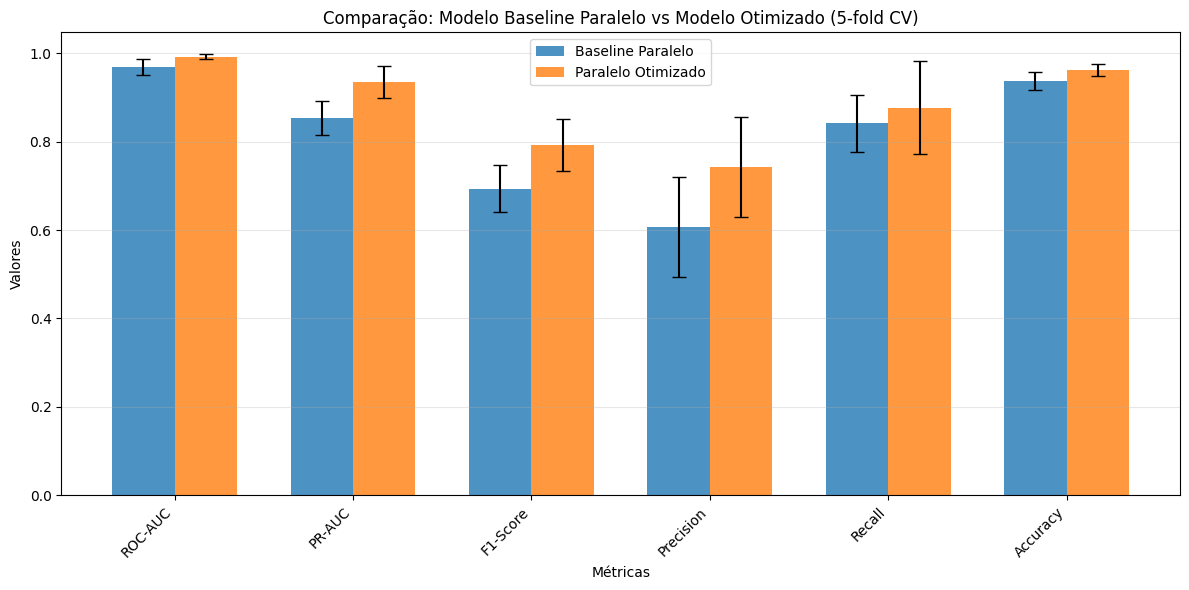

In [20]:
# Comparação entre modelo baseline e modelo otimizado
print("=== Comparação: Baseline Paralelo vs Otimizado ===\n")

comparison_df = pd.DataFrame({
    'Métrica': ['ROC-AUC', 'PR-AUC', 'F1-Score', 'Precision', 'Recall', 'Accuracy'],
    'Baseline (Mean)': [
        np.mean(metrics['roc_auc']),
        np.mean(metrics['pr_auc']),
        np.mean(metrics['f1']),
        np.mean(metrics['precision']),
        np.mean(metrics['recall']),
        np.mean(metrics['accuracy'])
    ],
    'Baseline (Std)': [
        np.std(metrics['roc_auc']),
        np.std(metrics['pr_auc']),
        np.std(metrics['f1']),
        np.std(metrics['precision']),
        np.std(metrics['recall']),
        np.std(metrics['accuracy'])
    ],
    'Otimizado (Mean)': [
        np.mean(optimized_metrics['roc_auc']),
        np.mean(optimized_metrics['pr_auc']),
        np.mean(optimized_metrics['f1']),
        np.mean(optimized_metrics['precision']),
        np.mean(optimized_metrics['recall']),
        np.mean(optimized_metrics['accuracy'])
    ],
    'Otimizado (Std)': [
        np.std(optimized_metrics['roc_auc']),
        np.std(optimized_metrics['pr_auc']),
        np.std(optimized_metrics['f1']),
        np.std(optimized_metrics['precision']),
        np.std(optimized_metrics['recall']),
        np.std(optimized_metrics['accuracy'])
    ]
})

comparison_df['Melhoria (%)'] = ((comparison_df['Otimizado (Mean)'] - comparison_df['Baseline (Mean)']) / comparison_df['Baseline (Mean)'] * 100).round(2)

print(comparison_df.to_string(index=False))

# Visualizar comparação
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df['Métrica']))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline (Mean)'], width, 
               yerr=comparison_df['Baseline (Std)'], label='Baseline Paralelo', capsize=5, alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Otimizado (Mean)'], width,
               yerr=comparison_df['Otimizado (Std)'], label='Paralelo Otimizado', capsize=5, alpha=0.8)

ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparação: Modelo Baseline Paralelo vs Modelo Otimizado (5-fold CV)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Métrica'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()